In [216]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy


Полносвязная модель

In [217]:
#hyper params
num_epoch = 18
cuda_device = -1
batch_size = 207
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
input_d = 28*28
hidden_d = 500
out_d = 10

In [218]:
#model
class MyModel(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 ):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.linear3 = nn.Linear(hidden_dim, out_dim)

        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.sigmoid(self.linear3(x))

        return x

In [219]:
def collate_fn(data):
    pics = []
    targets = []
    # data = [(pic, target), ....]
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255, # нормирование в диапазон [0, 1]
        'target': torch.from_numpy(numpy.array(targets))
    }

In [220]:
# init model
model = MyModel(input_d, hidden_d, out_d)
model = model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#lr scheduler
dataset = datasets.MNIST('/Users/a14419009/Repos/NN_reload_stream2', download=True)
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/a14419009/Repos/NN_reload_stream2
    Split: Train

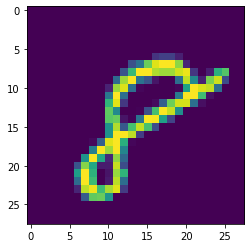

In [221]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[59999].detach().numpy())
plt.show()

In [222]:
### Почему датасет с новым форматом возвращает нули?
data = batch['data'].to(device).float()
data.view(data.size(0), -1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [223]:
#loss
criterion = nn.CrossEntropyLoss()

# train loop
for epoch in range(num_epoch):
    #dataloder
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    optim.zero_grad()
    for i, batch in enumerate(data_loader):
        # batch['data'] - > B x W x H -> B x W*H
        data = batch['data'].to(device).float()
        predict = model(data.view(data.size(0), -1))
        loss = criterion(predict, batch['target'].to(device).type(torch.LongTensor))
        loss.backward()
        if i % 2 == 0:
            optim.step()
            optim.zero_grad()
        if i % 100:
            print(loss)
        # сохранение модели каждые n шагов

tensor(2.2886, grad_fn=<NllLossBackward0>)
tensor(2.2884, grad_fn=<NllLossBackward0>)
tensor(2.2714, grad_fn=<NllLossBackward0>)
tensor(2.2693, grad_fn=<NllLossBackward0>)
tensor(2.2475, grad_fn=<NllLossBackward0>)
tensor(2.2447, grad_fn=<NllLossBackward0>)
tensor(2.2076, grad_fn=<NllLossBackward0>)
tensor(2.2086, grad_fn=<NllLossBackward0>)
tensor(2.1744, grad_fn=<NllLossBackward0>)
tensor(2.1720, grad_fn=<NllLossBackward0>)
tensor(2.1303, grad_fn=<NllLossBackward0>)
tensor(2.1253, grad_fn=<NllLossBackward0>)
tensor(2.0803, grad_fn=<NllLossBackward0>)
tensor(2.0883, grad_fn=<NllLossBackward0>)
tensor(2.0462, grad_fn=<NllLossBackward0>)
tensor(2.0257, grad_fn=<NllLossBackward0>)
tensor(1.9724, grad_fn=<NllLossBackward0>)
tensor(1.9750, grad_fn=<NllLossBackward0>)
tensor(1.9462, grad_fn=<NllLossBackward0>)
tensor(1.9374, grad_fn=<NllLossBackward0>)
tensor(1.8890, grad_fn=<NllLossBackward0>)
tensor(1.8700, grad_fn=<NllLossBackward0>)
tensor(1.8501, grad_fn=<NllLossBackward0>)
tensor(1.88

In [224]:
model.train()

MyModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=10, bias=True)
  (activation): ReLU()
  (sigmoid): Sigmoid()
)

In [225]:
with torch.no_grad():
    model.eval()
    pred = model(dataset.data[5].float().view(-1))

pred

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

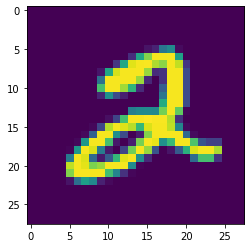

In [226]:
plt.imshow(dataset.data[5].detach().numpy())
plt.show()

Сверточная сеть на Minist

In [227]:
#hyper params
num_epoch = 1
cuda_device = -1
batch_size = 201
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
input_d = 1
hidden_d = 490
hidden_d1 = 200
hidden_d2 = 100
hidden_d3 = 110
out_d = 10

In [228]:
def collate_fn(data):
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

In [229]:
### Pooling, BatchNorm, Conv не увиличивают размерность, в связи с чем она растет до 4?

class MyModelCNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels1: int,
                 hidden_channels2: int,
                 hidden_channels3: int,
                 n_classes: int,
                 ):
        super().__init__()
        # TODO change architecture
        # TODO use pooling
        self.pool = nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        self.conv1 = nn.Conv2d(in_channels, hidden_channels1, kernel_size=5, padding=2, stride=2) # 14 * 14
        # TODO add batchnorm after each conv
        self.bn1 = nn.BatchNorm2d(hidden_channels1)
        self.conv2 = nn.Conv2d(hidden_channels1, hidden_channels2, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels2)
        self.conv3 = nn.Conv2d(hidden_channels2, hidden_channels3, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels3)
        self.conv4 = nn.Conv2d(hidden_channels3, 1, kernel_size=1, padding=0, stride=1)
        self.linear1 = nn.Linear(14*14, n_classes, bias=True)

        self.activation = nn.ReLU()

    def forward(self, x):
        print(x.size())
        # plt.imshow(x[0][0])
        # plt.show()
        x = self.pool(x)
        print(x.size())
        # plt.imshow(x[0][0])
        # plt.show()
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.conv4(x))
        x = self.activation(self.linear1(x.view(x.size(0), -1)))

        return x

In [230]:
# init model
model = MyModelCNN(input_d, hidden_d1, hidden_d2, hidden_d3, out_d)
model = model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [231]:
import time

#loss
criterion = nn.CrossEntropyLoss()

time_start = time.time()

In [232]:
# train loop
for epoch in range(num_epoch):
    #dataloder
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for i, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = model(data.unsqueeze(1)) # B x W x H -> B x 1 x W x H
        loss = criterion(predict, batch['target'].to(device).type(torch.LongTensor))
        loss.backward()
        optim.step()
        if i % 100000:
            print('    ' + str(loss))

print('Обучение завершилось за: ' + time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start)))

torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.2912, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.2404, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.1908, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.1269, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.1250, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(2.0198, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(1.8614, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(1.8983, grad_fn=<NllLossBackward0>)
torch.Size([201, 1, 28, 28])
torch.Size([201, 1, 28, 28])
    tensor(1.9072, grad_fn=<NllLossBackward0

In [233]:
model.train()

MyModelCNN(
  (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
  (conv1): Conv2d(1, 200, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(100, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(110, 1, kernel_size=(1, 1), stride=(1, 1))
  (linear1): Linear(in_features=196, out_features=10, bias=True)
  (activation): ReLU()
)

In [234]:
### Почему не получаем принадлежность классу (0, 1)?
### no grad 

idx = 200

with torch.no_grad():
    model.eval()
    pred = model(dataset.data[idx].float().unsqueeze(0).unsqueeze(0))
pred

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


tensor([[   0.0000, 1170.8079,    0.0000,   57.3576,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000]])

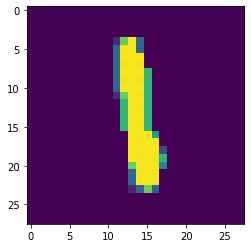

In [235]:
plt.imshow(dataset.data[200].detach().numpy())
plt.show()